In [1]:
# LSTM 单层 LSTM 的结构

In [2]:
# 准备数据
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import pandas as pd
import time
import random
import matplotlib.pyplot as plt

In [3]:
np.random.seed(1027)
torch.manual_seed(1027)
torch.cuda.manual_seed(1027)
torch.backends.cudnn.deterministic = True

In [4]:
# 设置 GPU 优先
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 加载数据
dataset = pd.read_csv("601229.csv", index_col=0)
dataset = dataset.drop(['date'], axis=1)
dataset = dataset.fillna(0)

In [5]:
# 将数据按照BATCH_SIZE的窗口进行滑动，每个窗口数据做一组
# # 数据转成sequence的格式，这里定义每个seq的长度
TRAIN_VALIDATION_RATIO = 0.7
TRAIN_BATCH_SIZE = 40                                                        # 注意：BATCH_SIZE是要能够整除(total_seq_count-1)的
TEST_BATCH_SIZE = 1
SEQ_LENGTH = 25
Y_SEQ_LEN = 1                                                         # 要用2个y来表示预测的第一天和预测的第二天，对应 "future" 和 "future2",每个y都是1-D的，y的seq_len是2
Y_DIM = 1
X_DIM = dataset.shape[1]-Y_SEQ_LEN                                    # 表示输入的sequence里每个element有122维度，也是encoder的input_dim

# 把数据切换成 BATCH_SIZE 的一个个batch
rolling_data = pd.DataFrame()
for i in dataset.rolling(SEQ_LENGTH):
    if i.shape[0] == SEQ_LENGTH:
        rolling_data = rolling_data.append(i)

rolling_data = rolling_data.values.reshape(-1, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)                   # 数据一共是 seq_count x seq_len x (x_in_dim+Y_SEQ_LEN) 

print("rolling_data shape: {}".format(rolling_data.shape))
print("seq count: {}".format(rolling_data.shape[0]))                                       # 所以一共有 seq_count 列数据，每一行的数据是123维 （包括y）
print("seq length: {}".format(SEQ_LENGTH))

# TEST_BATCH_COUNT  = (rolling_data.shape[0])%TRAIN_BATCH_SIZE
TEST_BATCH_SIZE  = (rolling_data.shape[0])%TRAIN_BATCH_SIZE
if TEST_BATCH_SIZE == 0:                                                                   # 如果 rolling_data 刚好被整除，那就专门留一整块给test，全部算一个batch
    TEST_BATCH_SIZE = TRAIN_BATCH_SIZE
TEST_BATCH_COUNT = 1
TRAIN_BATCH_COUNT = int(((rolling_data.shape[0]-TEST_BATCH_SIZE*TEST_BATCH_COUNT)//TRAIN_BATCH_SIZE) * TRAIN_VALIDATION_RATIO)
VALID_BATCH_COUNT = int(((rolling_data.shape[0]-TEST_BATCH_SIZE*TEST_BATCH_COUNT)//TRAIN_BATCH_SIZE) - TRAIN_BATCH_COUNT)

print("TRAIN_BATCH_COUNT : {}".format(TRAIN_BATCH_COUNT))
print("VALID_BATCH_COUNT : {}".format(VALID_BATCH_COUNT))
print("TEST_BATCH_COUNT  : {}".format(TEST_BATCH_COUNT))

# train = rolling_data[:-test_seq_count].reshape(-1, BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)           # 把数据转成 tain_batch_count x BATCH_SIZE x seq_len x in_dim 格式
# test  = rolling_data[-test_seq_count:].reshape(-1, BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)           # 把数据转成 test_batch_count x BATCH_SIZE x seq_len x in_dim 格式

train = rolling_data[:TRAIN_BATCH_COUNT*TRAIN_BATCH_SIZE].reshape(TRAIN_BATCH_COUNT, TRAIN_BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_DIM*Y_SEQ_LEN)                    # 把数据转成 tain_batch_count x TRAIN_BATCH_SIZE x seq_len x in_dim 格式
valid = rolling_data[TRAIN_BATCH_COUNT*TRAIN_BATCH_SIZE:-TEST_BATCH_COUNT*TEST_BATCH_SIZE].reshape(VALID_BATCH_COUNT, TRAIN_BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_DIM*Y_SEQ_LEN)     # 把数据转成 tain_batch_count x TRAIN_BATCH_SIZE x seq_len x in_dim 格式
test  = rolling_data[-TEST_BATCH_COUNT*TEST_BATCH_SIZE:].reshape(TEST_BATCH_COUNT, TEST_BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_DIM*Y_SEQ_LEN)                     # 把数据转成 test_batch_count x TEST_BATCH_SIZE x seq_len x in_dim 格式

TRAIN_BATCH_COUNT = train.shape[0]
TRAIN_BATCH_SIZE = train.shape[1]
VALID_BATCH_COUNT = valid.shape[0]
VALID_BATCH_SIZE = valid.shape[1]
TEST_BATCH_COUNT = test.shape[0]
TEST_BATCH_SIZE = test.shape[1]

train = torch.tensor(train)
valid = torch.tensor(valid)
test  = torch.tensor(test)


train_x, train_y = train[:,:,:,Y_SEQ_LEN:], train[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]
valid_x, valid_y = valid[:,:,:,Y_SEQ_LEN:], valid[:,:,-1:,0:Y_SEQ_LEN]           # [valid_batch_count, batch_size, sequence_length, XorY dimission]
test_x,  test_y  = test[:,:,:, Y_SEQ_LEN:],  test[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]

train_y = train_y.permute(0, 1, 3, 2)                                    # conver from [train_batch_count, batch_size, seq_length, y_seq_len]  to [train_batch_count, batch_size, y_seq_len, 1-dim]
valid_y = valid_y.permute(0, 1, 3, 2)                                    # conver from [train_batch_count, batch_size, seq_length, y_seq_len]  to [train_batch_count, batch_size, y_seq_len, 1-dim]
test_y  =  test_y.permute(0, 1, 3, 2)                                    # conver from [test_batch_count, batch_size, seq_length, y_seq_len]  to  [test_batch_count, batch_size, y_seq_len, 1-dim]


train_x = train_x.to(device)
train_y = train_y.to(device)
valid_x = valid_x.to(device)
valid_y = valid_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)

print("train_x: {}".format(train_x.shape))
print("train_y: {}".format(train_y.shape))
print("valid_x: {}".format(valid_x.shape))
print("valid_y: {}".format(valid_y.shape))
print("test_x:  {}".format(test_x.shape))
print("test_y:  {}".format(test_y.shape))
print("train_batch_count: {}".format(train.shape[0]))
print("valid_batch_count: {}".format(valid.shape[0]))
print("test_batch_count:  {}".format(test.shape[0]))

rolling_data shape: (645, 25, 139)
seq count: 645
seq length: 25
TRAIN_BATCH_COUNT : 11
VALID_BATCH_COUNT : 5
TEST_BATCH_COUNT  : 1
train_x: torch.Size([11, 40, 25, 138])
train_y: torch.Size([11, 40, 1, 1])
valid_x: torch.Size([5, 40, 25, 138])
valid_y: torch.Size([5, 40, 1, 1])
test_x:  torch.Size([1, 5, 25, 138])
test_y:  torch.Size([1, 5, 1, 1])
train_batch_count: 11
valid_batch_count: 5
test_batch_count:  1


In [6]:
# 定义 LSTM 模型


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_dim_size, num_layers, output_size, dropout=0.1):
        super().__init__()
        self.linear_1 = nn.Linear(input_size, hidden_dim_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_dim_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(hidden_dim_size, output_size)

        # self.h0 = torch.zeros(NUM_LAYERS, BATCH_SIZE, hidden_dim_size).double().to(device)
        # self.c0 = torch.zeros(NUM_LAYERS, BATCH_SIZE, hidden_dim_size).double().to(device)
        
        self.init_weights2()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)

    def init_weights2(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.kaiming_normal_(param)    
    
    def init_weights3(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.orthogonal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
                
    def forward(self, x, hidden, cell):

        x = self.dropout(x)
        
        lstm_out, (h_n, c_n) = self.lstm(x, (hidden, cell))
        
        lstm_out = self.dropout(lstm_out)

        predictions = self.linear_2(lstm_out)
        
        return predictions, h_n, c_n


In [7]:
# 训练 LSTM 模型 ---- 这里的损失函数是计算Sequence最后一个元素的预测数据和真实数据差异

HIDDEN_SIZE = 768
NUM_LAYERS = 3

def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

model = LSTMModel(input_size=X_DIM, hidden_dim_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_size=1).double().to(device)
LR = 1e-5
loss_func = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1, last_epoch=-1)

9 of 200 epoch   train_loss: 23.306770   valid_loss: 11.637865
19 of 200 epoch   train_loss: 0.274248   valid_loss: 1.463458
29 of 200 epoch   train_loss: 0.161077   valid_loss: 0.861150
39 of 200 epoch   train_loss: 0.067653   valid_loss: 0.681241
49 of 200 epoch   train_loss: 0.043137   valid_loss: 0.658515
59 of 200 epoch   train_loss: 0.040276   valid_loss: 0.563612
69 of 200 epoch   train_loss: 0.039899   valid_loss: 0.639053
79 of 200 epoch   train_loss: 0.035773   valid_loss: 0.531135
89 of 200 epoch   train_loss: 0.037236   valid_loss: 0.566670
99 of 200 epoch   train_loss: 0.034574   valid_loss: 0.547208
109 of 200 epoch   train_loss: 0.032845   valid_loss: 0.508517
119 of 200 epoch   train_loss: 0.035741   valid_loss: 0.613377
129 of 200 epoch   train_loss: 0.032225   valid_loss: 0.580645
139 of 200 epoch   train_loss: 0.029493   valid_loss: 0.581247
149 of 200 epoch   train_loss: 0.031327   valid_loss: 0.556803
159 of 200 epoch   train_loss: 0.032449   valid_loss: 0.538280
1

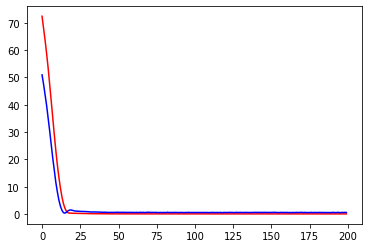

In [8]:
# 训练 LSTM 模型;  ---- 这里的损失函数是计算Sequence最后一个元素的预测数据和真实数据差异
model.train()
epoches = 200
train_epoch_loss = 0
train_epoch_loss_list = []
valid_smallest_loss = 1
valid_smallest_epoch = 0
valid_epoch_loss = 0
valid_epoch_loss_list = []

train_batch_count = train_x.shape[0]
valid_batch_count = valid_x.shape[0]

h0 = torch.zeros(NUM_LAYERS, TRAIN_BATCH_SIZE, HIDDEN_SIZE).double().to(device)
c0 = torch.zeros(NUM_LAYERS, TRAIN_BATCH_SIZE, HIDDEN_SIZE).double().to(device)


for epoch in range(epoches):
    batch_loss = []
    train_epoch_loss = 0
    train_pred_value_list = []
    train_real_value_list = []
    train_batch_list = list(range(0,train_batch_count))
    # random.shuffle(train_batch_list)
    for step in train_batch_list:
        train_pred, hn, cn = model(train_x[step], h0, c0)
        # h0, c0 = hn.detach(), cn.detach()
        loss = loss_func(train_pred[:,-1,-1], train_y[step][:,-1,-1])                # Compare the all sequences' last element in one batch
        train_pred_value_list.extend(list(train_pred[:,-1].cpu().detach().flatten().numpy() ))
        train_real_value_list.extend(list(train_y[step,:,-1,-1].cpu().detach().flatten().numpy() ))
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
        optimizer.step()
        batch_loss.append(loss.cpu().data.numpy())
    # print(batch_loss)
    train_epoch_loss = np.mean(batch_loss)

    batch_loss = []
    valid_epoch_loss = 0
    valid_pred_value_list = []
    valid_real_value_list = []
    for step in range(valid_batch_count):
        valid_pred, hn, cn = model(valid_x[step], h0, c0)
        loss = loss_func(valid_pred[:,-1,-1], valid_y[step][:,-1,-1])
        valid_pred_value_list.extend(list(valid_pred[:,-1].cpu().detach().flatten().numpy()))
        valid_real_value_list.extend(list(valid_y[step,:,-1,-1].cpu().detach().flatten().numpy()))
        batch_loss.append(loss.cpu().data.numpy())
    # print(batch_loss)
    valid_epoch_loss = np.mean(batch_loss)
    
    if ((epoch+1) %10) == 0:
        print("{} of {} epoch   train_loss: {:.6f}   valid_loss: {:.6f}".format(epoch, epoches, train_epoch_loss, valid_epoch_loss))

    valid_epoch_loss_list.append(valid_epoch_loss)
    train_epoch_loss_list.append(train_epoch_loss)

plt.plot(train_epoch_loss_list, 'r-')
plt.plot(valid_epoch_loss_list, 'b-')
plt.show()    

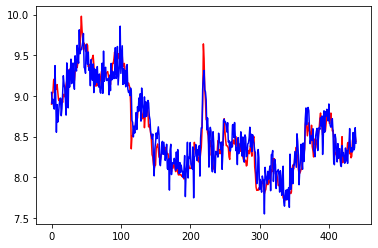

In [9]:
# 这是 train 的预测图形
plt.plot(train_real_value_list, 'r-')
plt.plot(train_pred_value_list, 'b-')
plt.show()
# print(train_real_value_list)

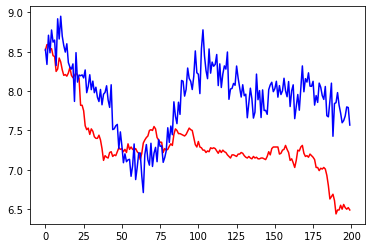

In [10]:
# 这是 vali的预测图形
plt.plot(valid_real_value_list, 'r-')
plt.plot(valid_pred_value_list, 'b-')
plt.show()

In [11]:
# 把rolling_data再分割为 train / test 就再预测
# 既然 预测值 和时序相关性很高，可以考虑太早的零星数据对于test影响不大，可以删掉
print(rolling_data.shape)
print(TRAIN_BATCH_SIZE)
print(((rolling_data.shape[0]-1)//TRAIN_BATCH_SIZE)*TRAIN_BATCH_SIZE)
rolling_data = rolling_data[-((rolling_data.shape[0]-1)//TRAIN_BATCH_SIZE)*TRAIN_BATCH_SIZE-1:,]
print(rolling_data.shape)

train = rolling_data[:-1].reshape(-1, TRAIN_BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_DIM*Y_SEQ_LEN)                    # 把数据转成 tain_batch_count x TRAIN_BATCH_SIZE x seq_len x in_dim 格式
test  = rolling_data[-1:].reshape(1, 1, SEQ_LENGTH, X_DIM+Y_DIM*Y_SEQ_LEN)                     # 把数据转成 test_batch_count x TEST_BATCH_SIZE x seq_len x in_dim 格式

train = torch.tensor(train).to(device)
test  = torch.tensor(test).to(device)

train_x, train_y = train[:,:,:,Y_SEQ_LEN:], train[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]
test_x,  test_y  = test[:,:,:, Y_SEQ_LEN:],  test[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)
print(test_y)

(645, 25, 139)
40
640
(641, 25, 139)
torch.Size([16, 40, 25, 138]) torch.Size([16, 40, 1, 1])
torch.Size([1, 1, 25, 138]) torch.Size([1, 1, 1, 1])
tensor([[[[0.]]]], device='cuda:0', dtype=torch.float64)


9 of 200 epoch   train_loss: 1.259905
19 of 200 epoch   train_loss: 0.401575
29 of 200 epoch   train_loss: 0.270458
39 of 200 epoch   train_loss: 0.224732
49 of 200 epoch   train_loss: 0.195202
59 of 200 epoch   train_loss: 0.197968
69 of 200 epoch   train_loss: 0.190337
79 of 200 epoch   train_loss: 0.182309
89 of 200 epoch   train_loss: 0.175069
99 of 200 epoch   train_loss: 0.183210
109 of 200 epoch   train_loss: 0.181449
119 of 200 epoch   train_loss: 0.179977
129 of 200 epoch   train_loss: 0.168898
139 of 200 epoch   train_loss: 0.170816
149 of 200 epoch   train_loss: 0.170692
159 of 200 epoch   train_loss: 0.173200
169 of 200 epoch   train_loss: 0.156529
179 of 200 epoch   train_loss: 0.168951
189 of 200 epoch   train_loss: 0.161447
199 of 200 epoch   train_loss: 0.158179


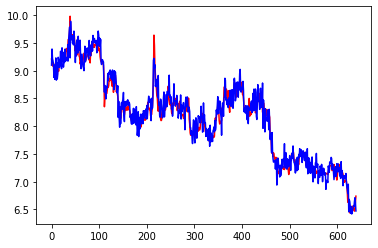

In [12]:
# 再重新生成模型再 train 模型
model = LSTMModel(input_size=X_DIM, hidden_dim_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_size=1).double().to(device)
LR = 1e-5
# loss_func = nn.MSELoss(reduction="mean")
loss_func = RMSELoss
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1, last_epoch=-1)
model.train()

h0 = torch.zeros(NUM_LAYERS, TRAIN_BATCH_SIZE, HIDDEN_SIZE).double().to(device)
c0 = torch.zeros(NUM_LAYERS, TRAIN_BATCH_SIZE, HIDDEN_SIZE).double().to(device)


for epoch in range(epoches):
    batch_loss = []
    train_epoch_loss = 0
    train_pred_value_list = []
    train_real_value_list = []
    train_batch_list = list(range(0,train_batch_count))
    # random.shuffle(train_batch_list)
    for step in range(0, train_x.shape[0]):
        train_pred, hn, cn = model(train_x[step], h0, c0)
        # h0, c0 = hn.detach(), cn.detach()
        loss = loss_func(train_pred[:,-1,-1], train_y[step][:,-1,-1])                # Compare the all sequences' last element in one batch
        train_pred_value_list.extend(list(train_pred[:,-1,-1].cpu().detach().flatten().numpy() ))
        train_real_value_list.extend(list(train_y[step,:,-1,-1].cpu().detach().flatten().numpy() ))
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
        optimizer.step()
        batch_loss.append(loss.cpu().data.numpy())
    if ((epoch+1) %10) == 0:
        print("{} of {} epoch   train_loss: {:.6f}".format(epoch, epoches, np.mean(batch_loss)))
    train_epoch_loss = np.mean(batch_loss)
    
plt.plot(train_real_value_list, 'r-')
plt.plot(train_pred_value_list, 'b-')
plt.show()    

In [13]:
print(train_pred.shape)
print(train_y.shape)

print(train_y[-1,-1])
print(train_pred[-1,-1])

torch.Size([40, 25, 1])
torch.Size([16, 40, 1, 1])
tensor([[6.7400]], device='cuda:0', dtype=torch.float64)
tensor([6.4729], device='cuda:0', dtype=torch.float64,
       grad_fn=<SelectBackward0>)


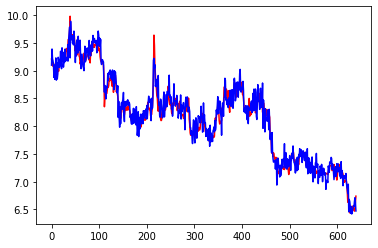

In [14]:
plt.plot(train_real_value_list, 'r-')
plt.plot(train_pred_value_list, 'b-')
plt.show()

In [15]:
# print(train_x.shape)
# print(test_x.shape)
print(train_real_value_list[-1])
print(train_pred_value_list[-1])

6.74
6.47292163774529


In [16]:
model.eval()

h0 = torch.zeros(NUM_LAYERS, test_x.shape[1], HIDDEN_SIZE).double().to(device)
c0 = torch.zeros(NUM_LAYERS, test_x.shape[1], HIDDEN_SIZE).double().to(device)

pred, hn, cn = model(test_x[-1], h0, c0)

print(test_y.shape)
print(pred.shape)
print(test_y)
print(pred[:,-1,:])

torch.Size([1, 1, 1, 1])
torch.Size([1, 25, 1])
tensor([[[[0.]]]], device='cuda:0', dtype=torch.float64)
tensor([[6.7850]], device='cuda:0', dtype=torch.float64,
       grad_fn=<SliceBackward0>)
